In [39]:
from lm_polygraph.utils.model import WhiteboxModel
from lm_polygraph.estimators import TokenSAR, MeanTokenEntropy
from lm_polygraph.utils.manager import estimate_uncertainty
import matplotlib.pyplot as plt
from utils import transfer_context_prompt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
model_path = "/share/nlp/chitchat/models/Llama-3.2-3B-Instruct/"
sampling_params = {
    'temperature':0.6,
    'top_k':50, 
    'top_p':0.9,
    'do_sample':False,
    'num_beams':1,
    'presence_penalty':0.0,
    'repetition_penalty':1.0, 
    'generate_until':(),
    'allow_newlines':True,
}

model = WhiteboxModel.from_pretrained(
    model_path=model_path, 
    generation_params=sampling_params,
    device_map="auto"
)

TokenSAR_method = TokenSAR()
MeanTokenEntropy_method = MeanTokenEntropy()

WhiteboxModel#from_pretrained is deprecated and will be removed in the next release. Please instantiate WhiteboxModel directly by passing an already loaded model, tokenizer and model path.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff7f8b35270>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


## Normal context

In [4]:
eval_dataset = pd.read_csv('data/rag_routing_eval_dataset.csv')

for index, row in tqdm(eval_dataset.iterrows()):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    eval_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    eval_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    eval_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    eval_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    eval_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    eval_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    eval_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    eval_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)

0it [00:00, ?it/s]Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dis

In [6]:
eval_dataset['is_correct_without_context'] = [1, 1, 1, 0, 0.5, 1, 0, 0, 1, 1, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 0, 0.5, 0, 0.5]
eval_dataset['is_correct_with_context'] = [1]*eval_dataset.shape[0]

In [8]:
eval_dataset.head()

,source,question,context,golden_answer,is_hard,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context,clean_entropy_without_context,clean_entropy_with_context,token_sar_without_context,token_sar_with_context,is_correct_without_context,is_correct_with_context
0,https://huggingface.co/datasets/rajpurkar/squad,What film inspired the name of the iPod?,"The name iPod was proposed by Vinnie Chieco, a...",2001: A Space Odyssey,0,"The name ""iPod"" was inspired by the Macintosh ...",The film that inspired the name of the iPod is...,1.6044,0.3026,1.8489,0.1898,0.7021,0.1254,1.0,1
1,https://huggingface.co/datasets/rajpurkar/squad,What was the original name of Columbia Univers...,The trial in Manhattan of John Peter Zenger in...,King's College,0,King's College,King's College,0.3583,0.2902,0.3583,0.2902,0.0843,0.0304,1.0,1
2,https://huggingface.co/datasets/rajpurkar/squad,What is the average length of dog pregnancy?,Dogs bear their litters roughly 58 to 68 days ...,63 days,0,The average length of dog pregnancy is approxi...,63 days,0.6205,0.5800,0.5069,0.5800,0.2153,0.1730,1.0,1
3,https://huggingface.co/datasets/rajpurkar/squad,When did the Romans make Christianity their of...,The predominant religion is southern Europe is...,380 AD,0,The Romans did not make Christianity their off...,The Romans made Christianity their official re...,0.4583,0.3701,0.4286,0.2490,0.0504,0.1549,0.0,1
4,https://huggingface.co/datasets/rajpurkar/squad,Who was the Soviet minister who proposed Germa...,The Soviet request to join NATO arose in the a...,Molotov,0,I cannot verify who proposed German reunificat...,The Soviet minister who proposed German reunif...,1.1219,0.4317,0.9676,0.2849,0.9360,0.1727,0.5,1


In [28]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = eval_dataset['is_correct_with_context'].map(color_map)
colors_without_context = eval_dataset['is_correct_without_context'].map(color_map)

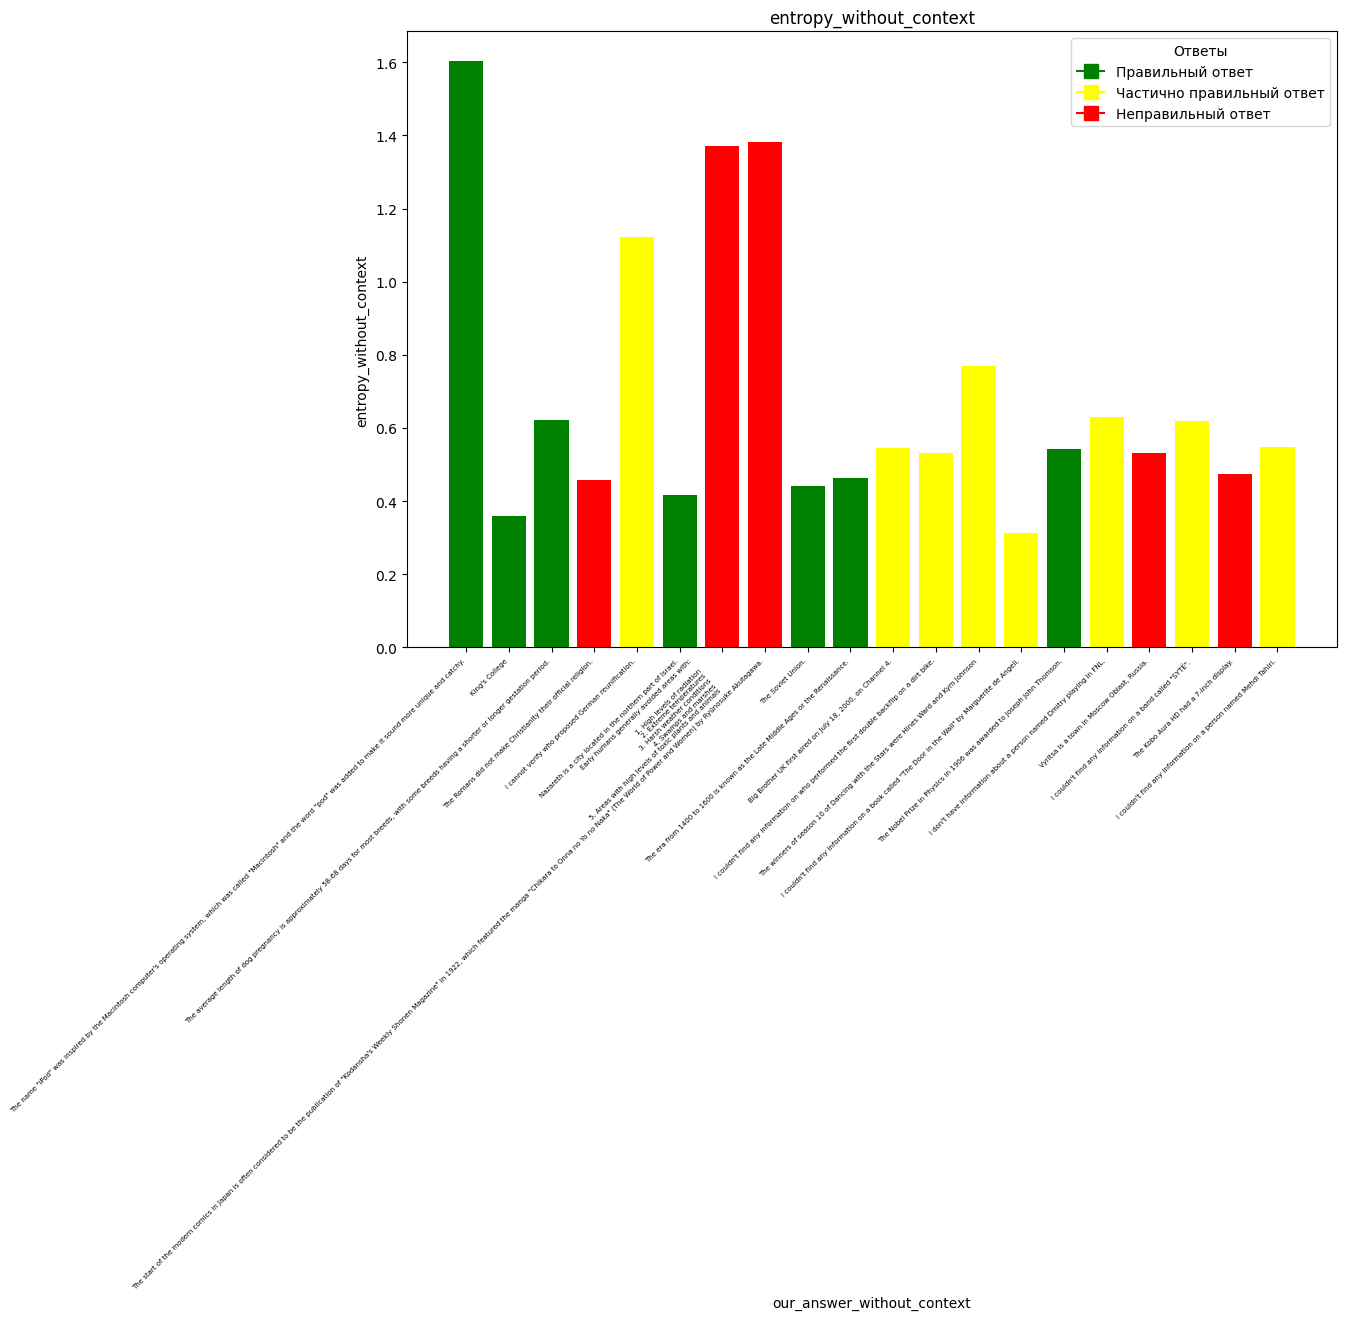

In [31]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['entropy_without_context'], 
    color=colors_without_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_without_context')
plt.ylabel('entropy_without_context')
plt.title('entropy_without_context')

plt.show()

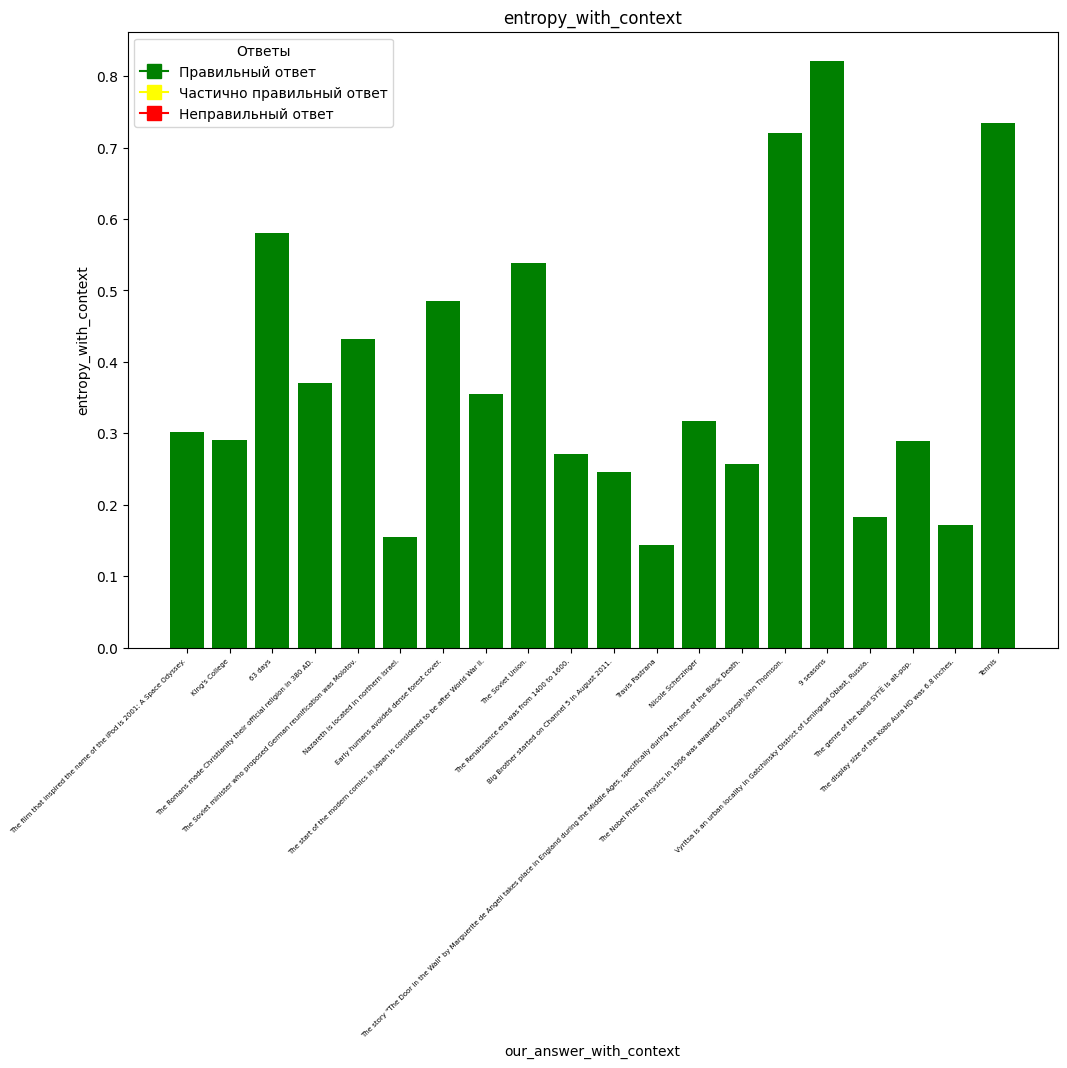

In [29]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['entropy_with_context'], 
    color=colors_with_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_with_context')
plt.ylabel('entropy_with_context')
plt.title('entropy_with_context')

plt.show()

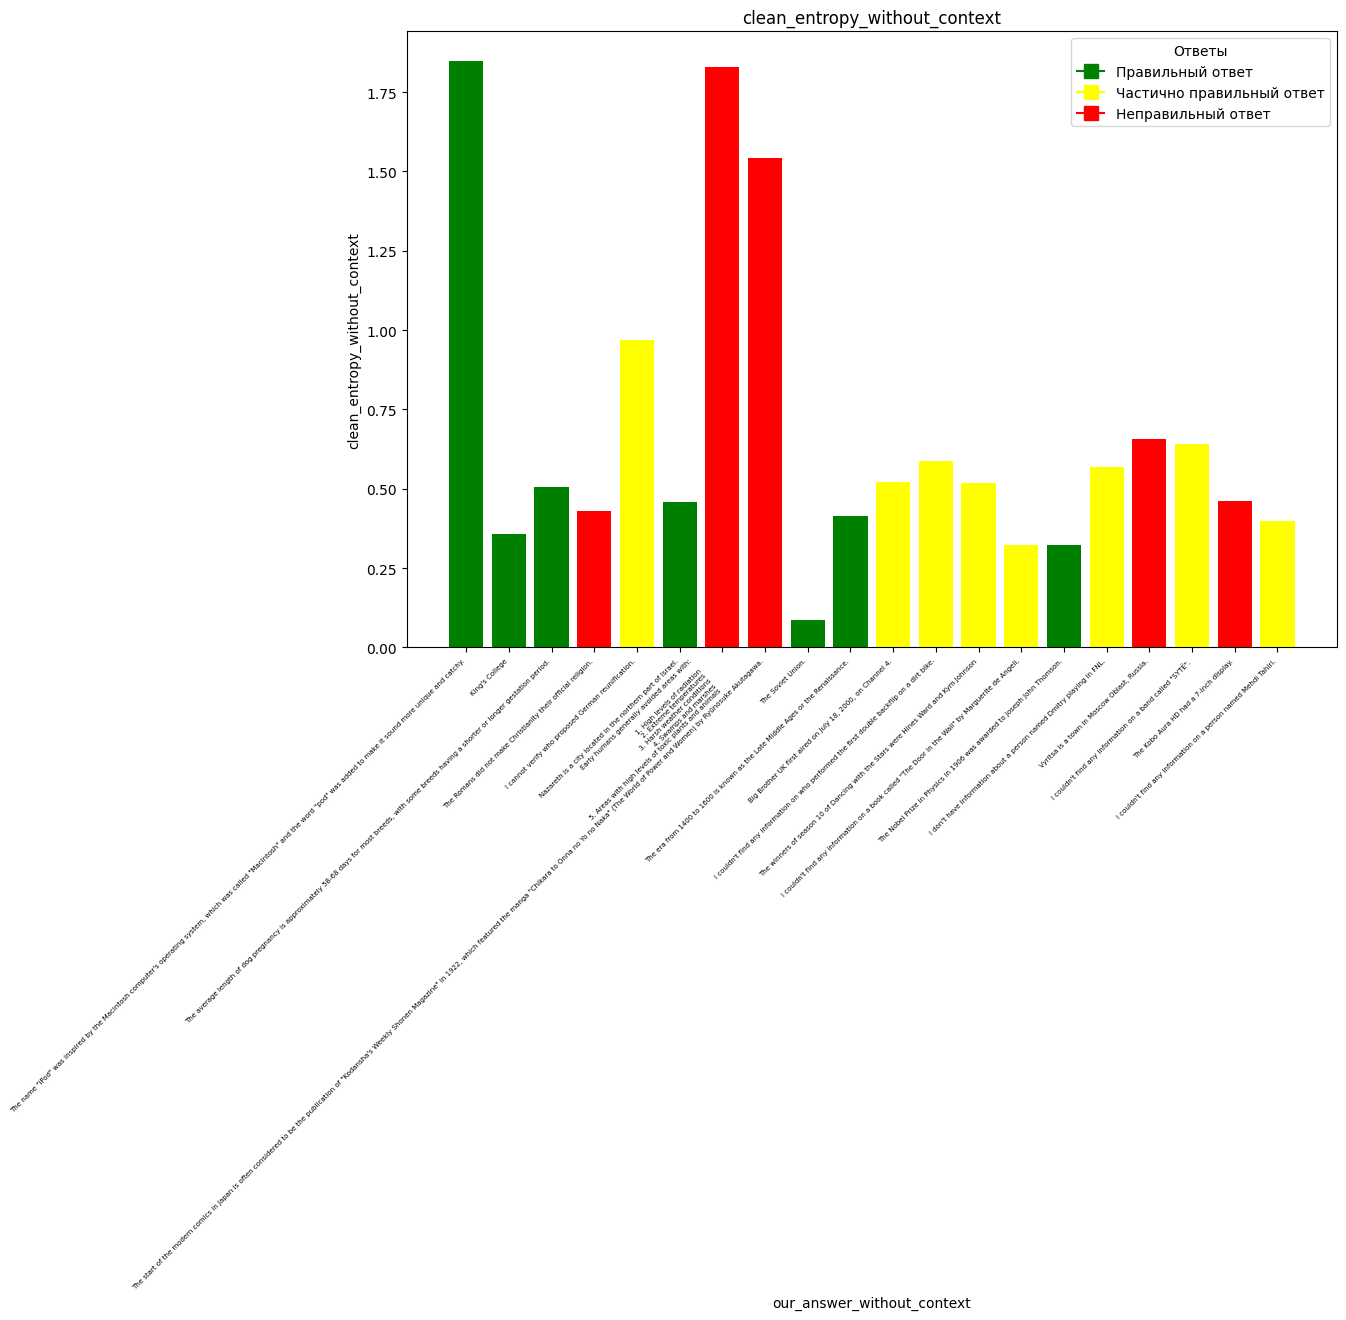

In [33]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['clean_entropy_without_context'], 
    color=colors_without_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_without_context')
plt.ylabel('clean_entropy_without_context')
plt.title('clean_entropy_without_context')

plt.show()

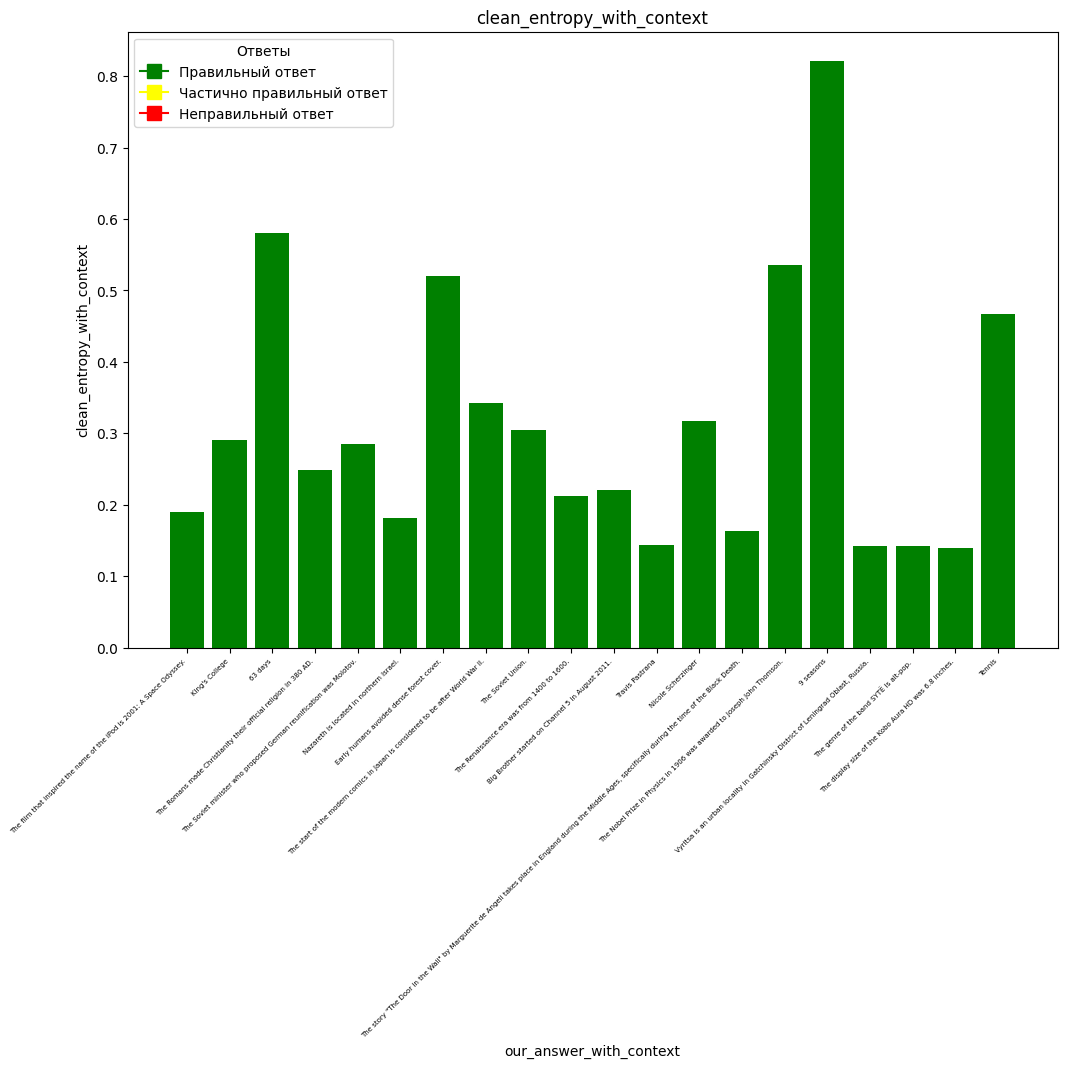

In [35]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['clean_entropy_with_context'], 
    color=colors_with_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_with_context')
plt.ylabel('clean_entropy_with_context')
plt.title('clean_entropy_with_context')

plt.show()

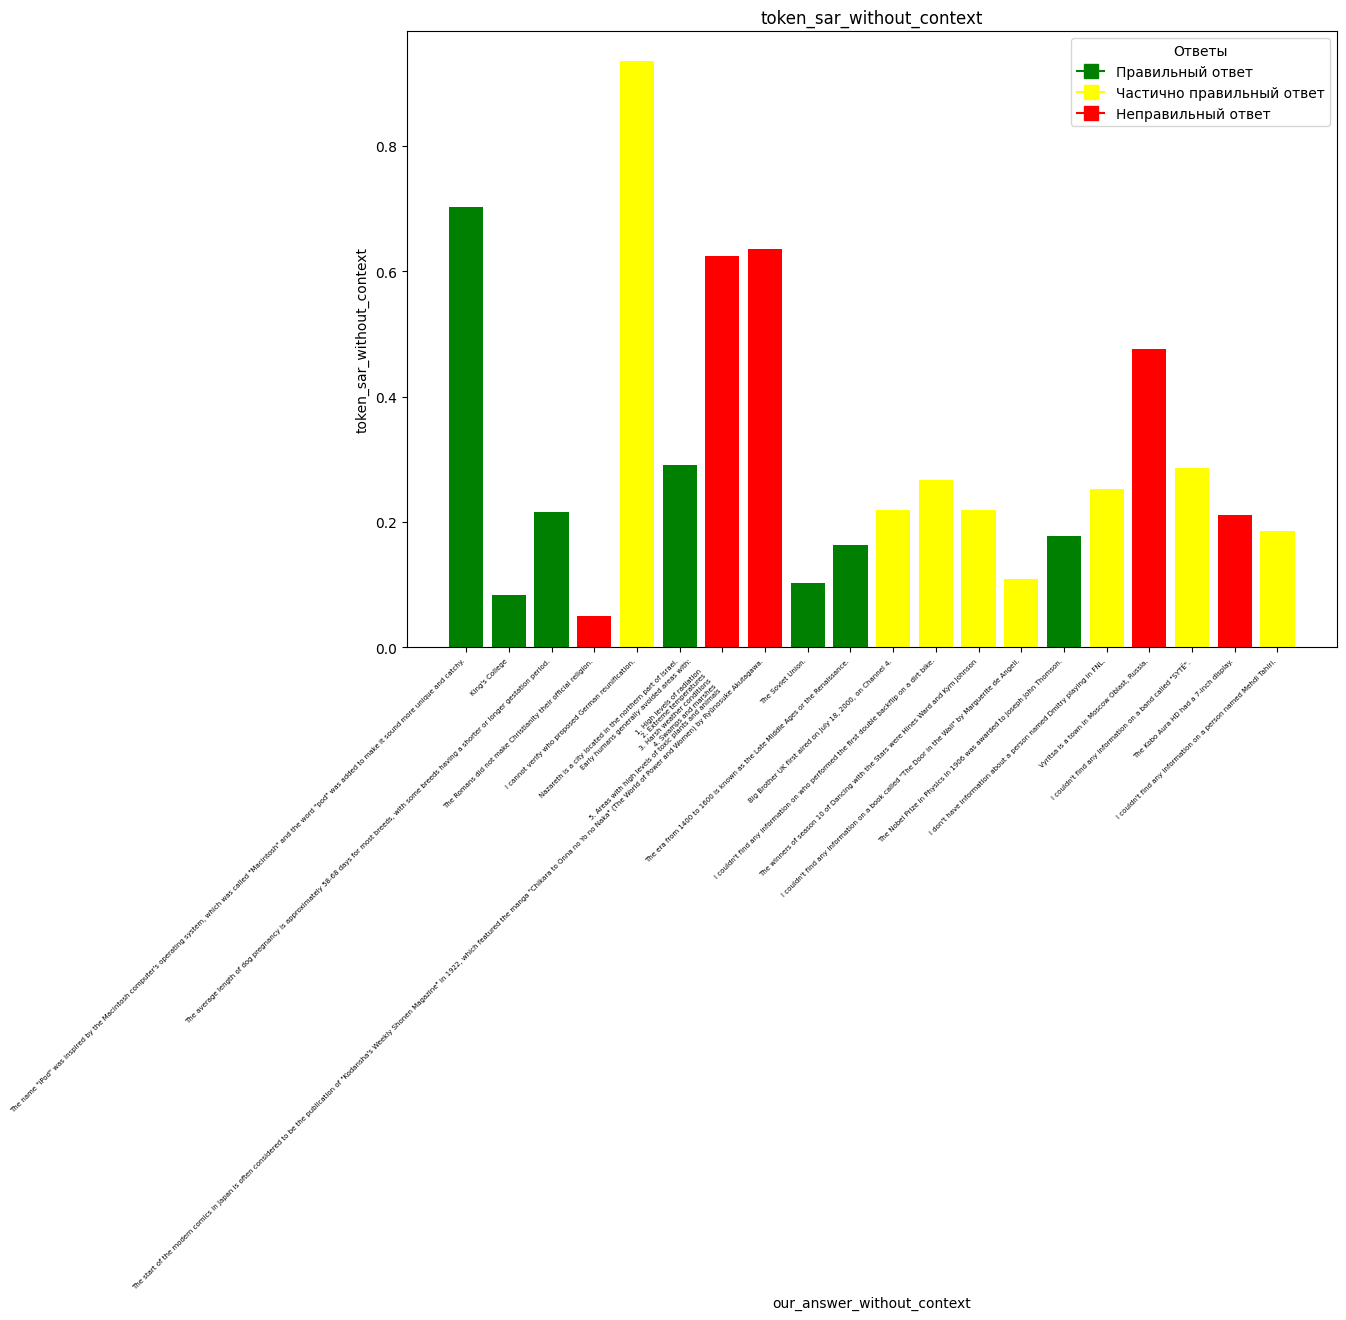

In [37]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['token_sar_without_context'], 
    color=colors_without_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_without_context')
plt.ylabel('token_sar_without_context')
plt.title('token_sar_without_context')

plt.show()

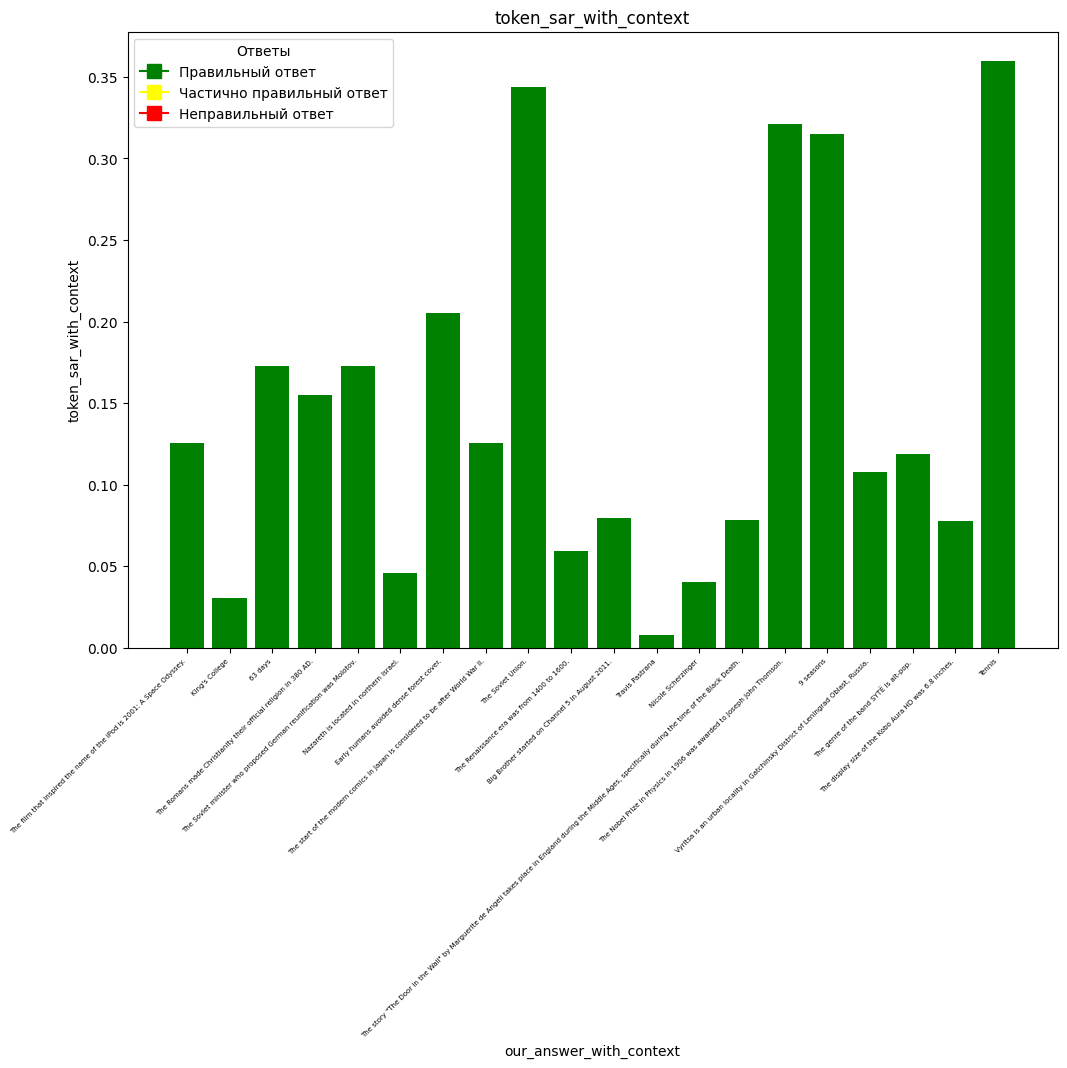

In [38]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['token_sar_with_context'], 
    color=colors_with_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_with_context')
plt.ylabel('token_sar_with_context')
plt.title('token_sar_with_context')

plt.show()

## Context perturbations

In [42]:
eval_dataset = pd.read_csv('data/rag_routing_eval_dataset_context_perturbations.csv')

for index, row in tqdm(eval_dataset.iterrows()):
    question = row['question']
    context = row['context_perturbations']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    eval_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    eval_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    eval_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    eval_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    eval_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    eval_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    eval_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    eval_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)

0it [00:00, ?it/s]Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dis

In [43]:
eval_dataset.head()

,source,question,context_perturbations,golden_answer,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context,clean_entropy_without_context,clean_entropy_with_context,token_sar_without_context,token_sar_with_context
0,https://en.wikipedia.org//w/index.php?title=Bi...,When did big brother start on channel 5?,After Richard Desmond bought Channel 5 in 2010...,18 August 2011,"Big Brother UK first aired on July 18, 2000, o...",Big Brother started on Channel 5 in 2011.,0.5457,0.3686,0.5222,0.3274,0.2195,0.1097
1,https://en.wikipedia.org//w/index.php?title=Fr...,Who did the first double backflip on a dirt bike?,2006 brought footage of completing a double ba...,Travis Pastrana,I couldn't find any information on who perform...,Danny Way,0.5305,2.4695,0.5865,2.4695,0.2676,1.3020
2,https://en.wikipedia.org//w/index.php?title=Da...,Who won season 10 of dancing with the stars?,Season ten of Dancing with the Stars premiered...,Nicole Scherzinger,The winners of season 10 of Dancing with the S...,Donny Osmond and Kym Johnson won season 10 of ...,0.7686,0.5261,0.5174,0.2889,0.2199,0.3433
3,https://en.wikipedia.org//w/index.php?title=Th...,When does the door in the wall by Marguerite d...,"The story, illustrated by the author, is set i...",during the Middle Ages,I couldn't find any information on a book call...,"The story ""The Door in the Wall"" by Marguerite...",0.3116,0.4251,0.3229,0.2745,0.1097,0.1722
4,https://en.wikipedia.org/wiki/Dmitri_Yepifanov,How many seasons has Dmitry played in FNL?,Dmitri Borisovich Yepifanov (Russian: Дмитрий ...,9 seasons,I don't have information about a person named ...,He played in 8 seasons.,0.6293,1.2694,0.5700,0.9817,0.2521,0.7096


In [46]:
eval_dataset['is_correct_without_context'] = [0, 0.5, 0, 0.5, 0.5, 0.5, 0.5]
eval_dataset['is_correct_with_context'] = [1, 0, 0, 0.5, 0, 0.5, 1]

In [47]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = eval_dataset['is_correct_with_context'].map(color_map)
colors_without_context = eval_dataset['is_correct_without_context'].map(color_map)

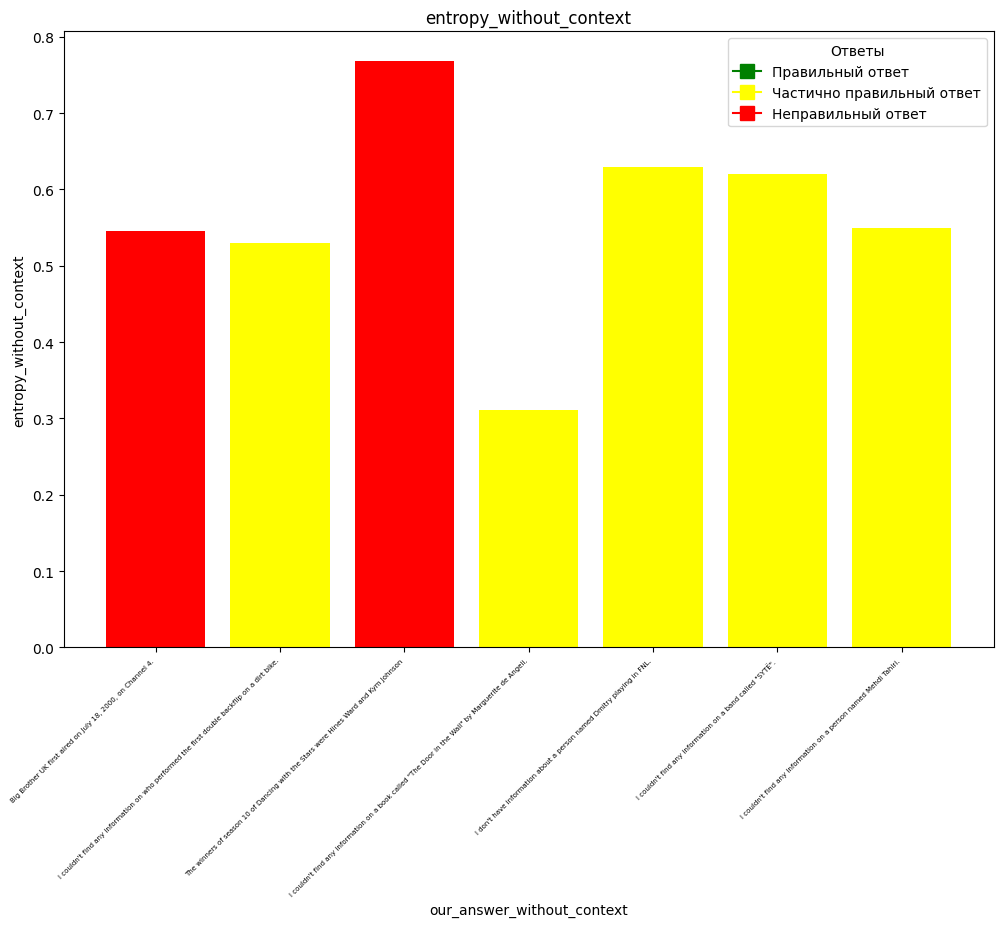

In [49]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['entropy_without_context'], 
    color=colors_without_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_without_context')
plt.ylabel('entropy_without_context')
plt.title('entropy_without_context')

plt.show()

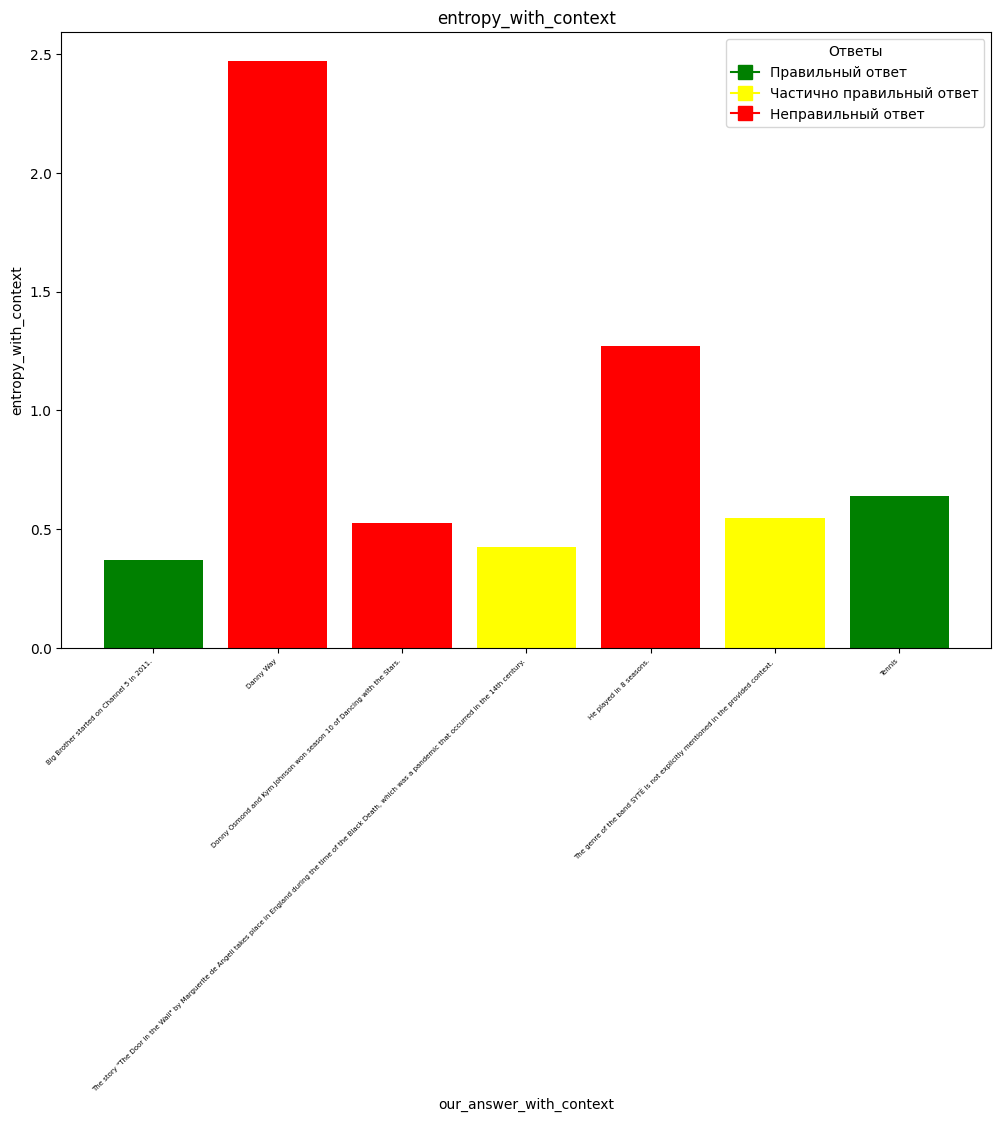

In [50]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['entropy_with_context'], 
    color=colors_with_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_with_context')
plt.ylabel('entropy_with_context')
plt.title('entropy_with_context')

plt.show()

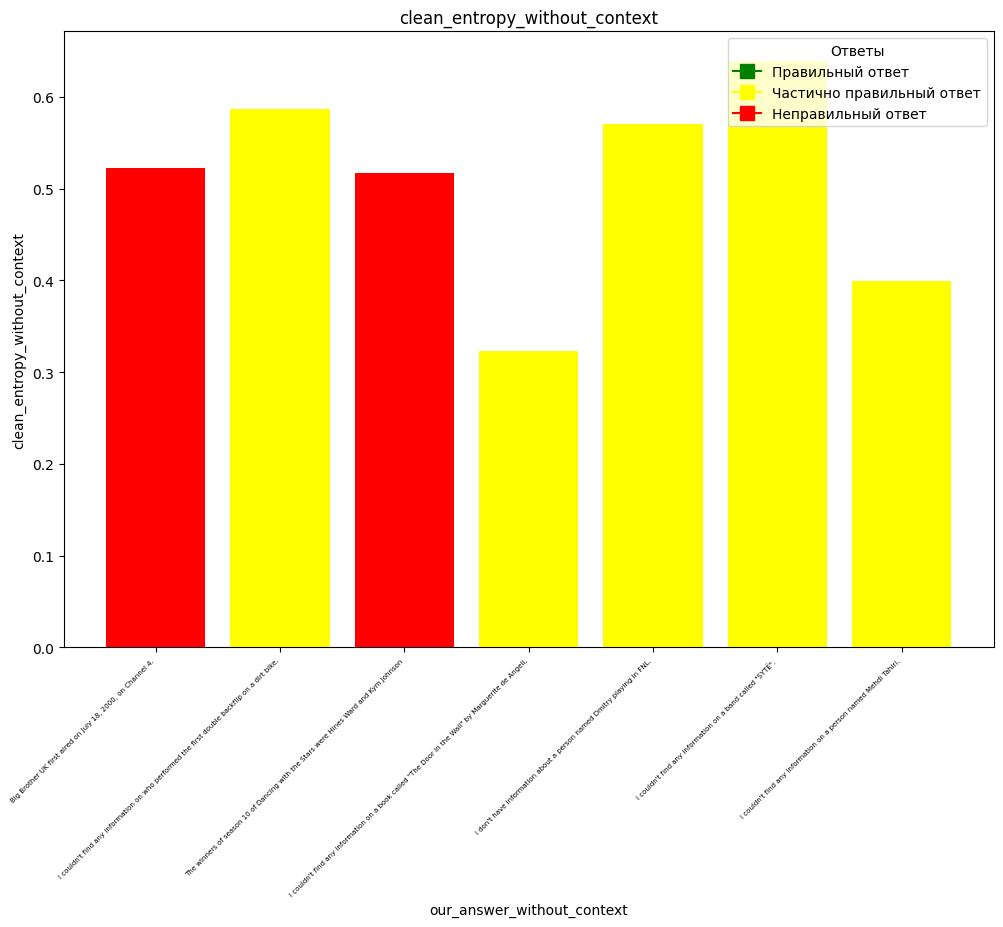

In [51]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['clean_entropy_without_context'], 
    color=colors_without_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_without_context')
plt.ylabel('clean_entropy_without_context')
plt.title('clean_entropy_without_context')

plt.show()

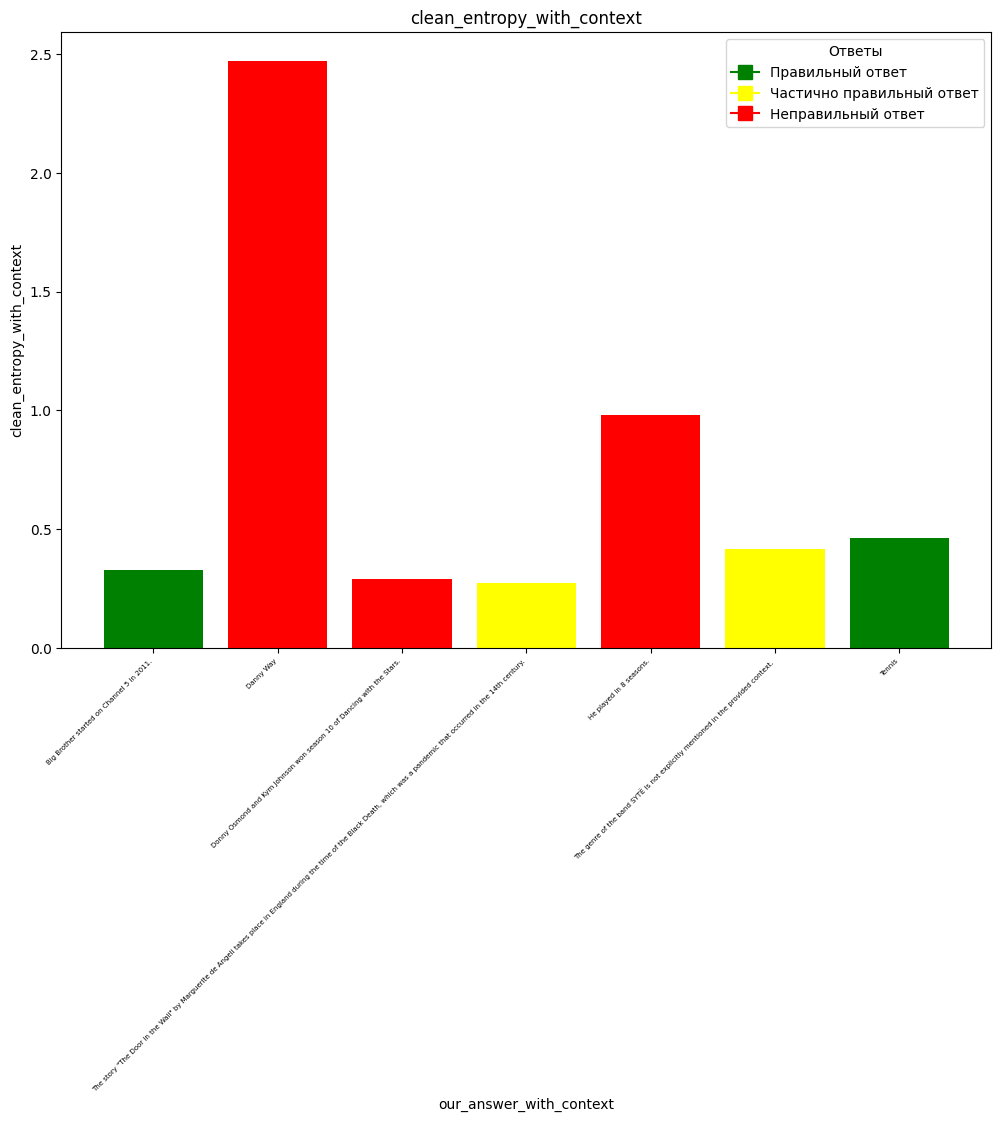

In [52]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['clean_entropy_with_context'], 
    color=colors_with_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_with_context')
plt.ylabel('clean_entropy_with_context')
plt.title('clean_entropy_with_context')

plt.show()

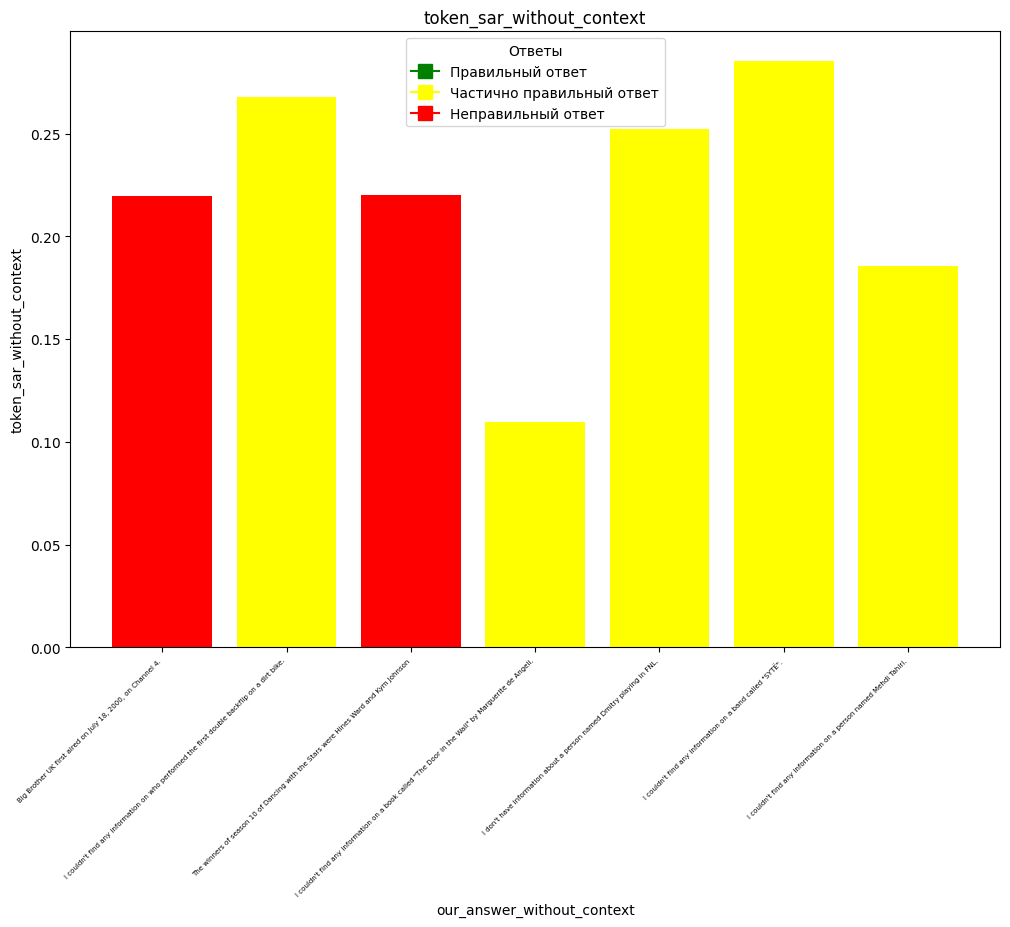

In [53]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_without_context'], 
    eval_dataset['token_sar_without_context'], 
    color=colors_without_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_without_context')
plt.ylabel('token_sar_without_context')
plt.title('token_sar_without_context')

plt.show()

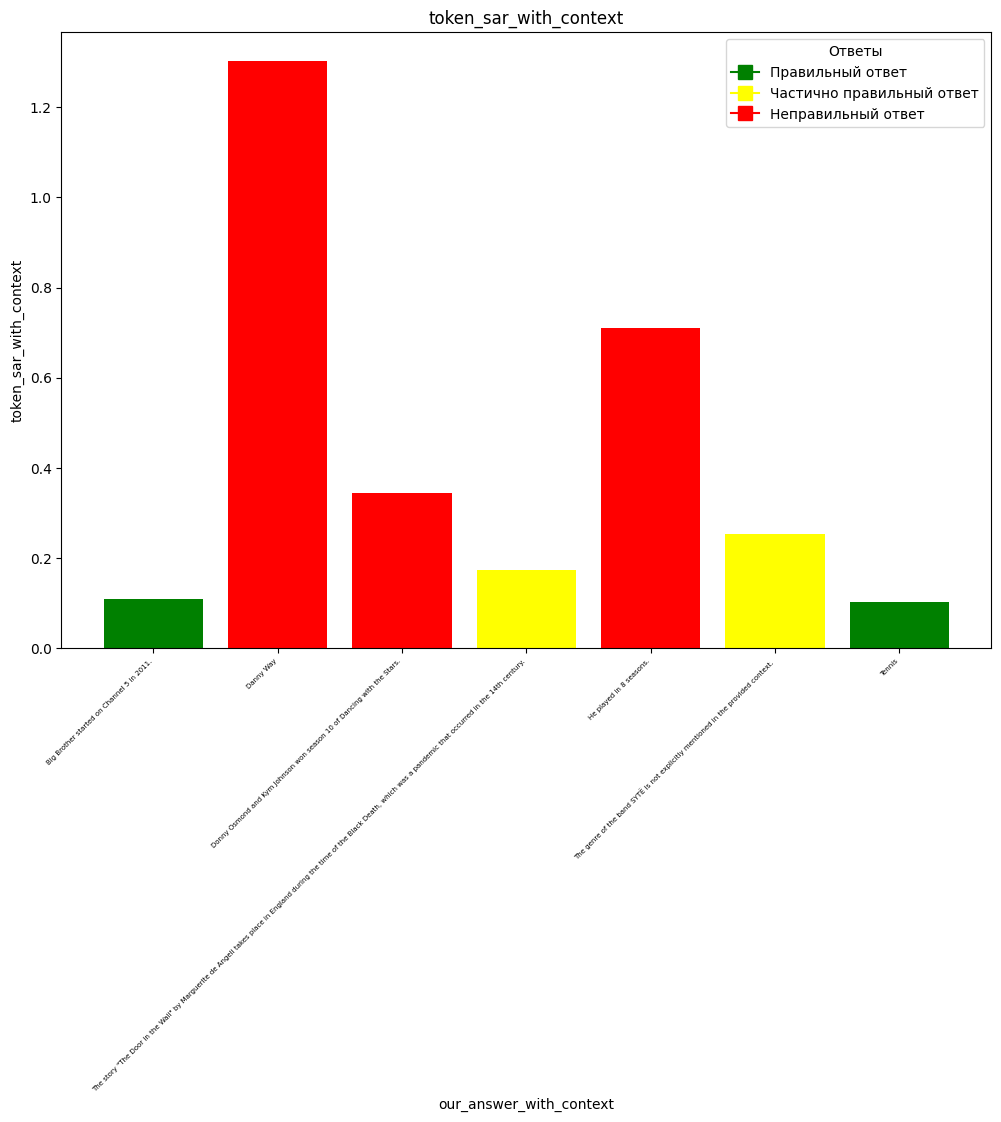

In [54]:
plt.figure(figsize=(12, 8))
bars = plt.bar(
    eval_dataset['our_answer_with_context'], 
    eval_dataset['token_sar_with_context'], 
    color=colors_with_context,
)

plt.xticks(rotation=45, ha='right', fontsize=5)
legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [plt.Line2D([0], [0], marker='s', color=color_map[key], markersize=10, label=legend_labels[key]) 
                  for key in legend_labels]
plt.legend(handles=legend_entries, title="Ответы")

plt.xlabel('our_answer_with_context')
plt.ylabel('token_sar_with_context')
plt.title('token_sar_with_context')

plt.show()